<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/finetuned_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.8.0+cu126
Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),

    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


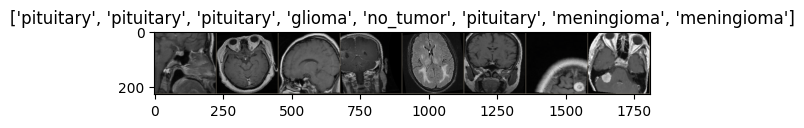

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")


Total params: 4012672
Total Trainable Parameters: 4012672


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [20]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy().tolist())
            all_labels.append(labels.cpu().numpy().tolist())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [21]:
NUM_EPOCHS = 25
best_val_acc = 0.0
best_model_path = 'efficientnetb0_brain_tumor.pth'
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/25


    train_loss: 0.1106    train_acc: 0.9640
    val_loss: 0.0933    val_acc: 0.9741
Saved new best model
Epoch 2/25


    train_loss: 0.0949    train_acc: 0.9693
    val_loss: 0.0766    val_acc: 0.9781
Saved new best model
Epoch 3/25


    train_loss: 0.0975    train_acc: 0.9670
    val_loss: 0.0881    val_acc: 0.9821
Saved new best model
Epoch 4/25


    train_loss: 0.1267    train_acc: 0.9522
    val_loss: 0.0789    val_acc: 0.9801
Epoch 5/25


    train_loss: 0.0915    train_acc: 0.9676
    val_loss: 0.0827    val_acc: 0.9781
Epoch 6/25


    train_loss: 0.0986    train_acc: 0.9640
    val_loss: 0.0948    val_acc: 0.9781
Epoch 7/25


    train_loss: 0.0819    train_acc: 0.9711
    val_loss: 0.0854    val_acc: 0.9841
Saved new best model
Epoch 8/25


    train_loss: 0.0839    train_acc: 0.9705
    val_loss: 0.0736    val_acc: 0.9781
Epoch 9/25


    train_loss: 0.0931    train_acc: 0.9670
    val_loss: 0.0677    val_acc: 0.9841
Epoch 10/25


    train_loss: 0.0662    train_acc: 0.9770
    val_loss: 0.0697    val_acc: 0.9821
Epoch 11/25


    train_loss: 0.0691    train_acc: 0.9776
    val_loss: 0.0754    val_acc: 0.9841
Epoch 12/25


    train_loss: 0.0628    train_acc: 0.9794
    val_loss: 0.0701    val_acc: 0.9841
Epoch 13/25


    train_loss: 0.0702    train_acc: 0.9764
    val_loss: 0.0712    val_acc: 0.9861
Saved new best model
Epoch 14/25


    train_loss: 0.0702    train_acc: 0.9764
    val_loss: 0.0721    val_acc: 0.9841
Epoch 15/25


    train_loss: 0.0630    train_acc: 0.9829
    val_loss: 0.0666    val_acc: 0.9880
Saved new best model
Epoch 16/25


    train_loss: 0.0660    train_acc: 0.9776
    val_loss: 0.0771    val_acc: 0.9801
Epoch 17/25


    train_loss: 0.0588    train_acc: 0.9811
    val_loss: 0.0688    val_acc: 0.9841
Epoch 18/25


    train_loss: 0.0716    train_acc: 0.9746
    val_loss: 0.0717    val_acc: 0.9841
Epoch 19/25


    train_loss: 0.0657    train_acc: 0.9758
    val_loss: 0.0629    val_acc: 0.9861
Epoch 20/25


    train_loss: 0.0656    train_acc: 0.9764
    val_loss: 0.0680    val_acc: 0.9861
Epoch 21/25


    train_loss: 0.0705    train_acc: 0.9752
    val_loss: 0.0738    val_acc: 0.9761
Epoch 22/25


    train_loss: 0.0575    train_acc: 0.9799
    val_loss: 0.0626    val_acc: 0.9861
Epoch 23/25


    train_loss: 0.0934    train_acc: 0.9658
    val_loss: 0.0730    val_acc: 0.9781
Epoch 24/25


    train_loss: 0.0824    train_acc: 0.9711
    val_loss: 0.0825    val_acc: 0.9761
Epoch 25/25


    train_loss: 0.0554    train_acc: 0.9794
    val_loss: 0.0818    val_acc: 0.9801
Training Complete in 11.38 minutes. Best val acc: 0.9880'


In [22]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.0666, acc: 0.9880


Confusion Matrix:
 [[161   0   0   0]
 [  0 120   4   0]
 [  0   0  97   2]
 [  0   0   0 118]]
Classification Report:
               precision    recall  f1-score   support

      glioma     1.0000    1.0000    1.0000       161
  meningioma     1.0000    0.9677    0.9836       124
    no_tumor     0.9604    0.9798    0.9700        99
   pituitary     0.9833    1.0000    0.9916       118

    accuracy                         0.9880       502
   macro avg     0.9859    0.9869    0.9863       502
weighted avg     0.9883    0.9880    0.9881       502



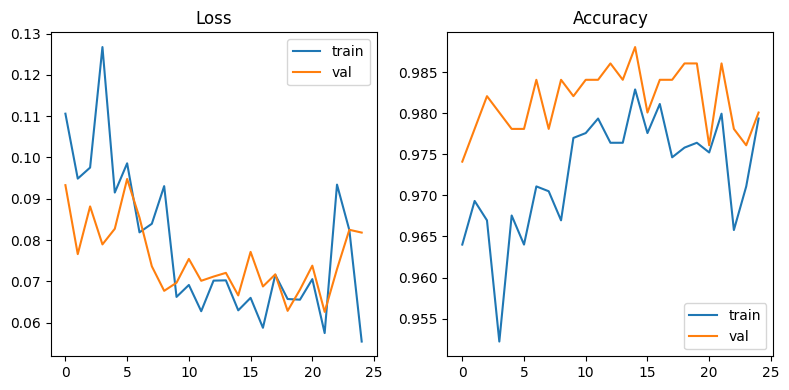

In [23]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()